In [7]:
#Import libraries

import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from pycm import ConfusionMatrix, Compare

import os

In [8]:
#Set variables

FOLD_NUMBER = 10
RANDOM_STATE = 23
METRIC_LIST = ["Accuracy", "F1", "Kappa", "Precision", "Recall"]

In [9]:
# Read data
df = pd.read_csv('./Data/merged.csv')
display(df.head())
print(df.shape)
# df = pd.read_csv("merged.csv")

,Address,Flag,Avg_min_between_received_tnx,Avg_min_between_sent_tnx,Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Average_of_Unique_Received_From_Addresses,Average_of_Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_including_tnx_to_create_contract,total_Ether_sent,total_ether_received,total_ether_balance
0,0x000000000532b45f47779fce440748893b257865,1,7.973236e+07,11971.000000,3,20,0,20,3,0.000410,14.331000,5.856601,39.041473,39.044000,39.043158,23,117.129473,117.132025,0.002551
1,0x00000000072d54638c2c2a3da3f715360269eea1,1,5.434648e+07,1281.695652,23,30,0,28,17,0.004312,208.090009,7.173130,0.000000,82.000000,9.389806,53,215.965533,215.193910,-0.771623
2,0x0000000009324b6434d7766af41908e4c49ee1d7,1,1.771695e+08,4494.500000,6,9,0,9,3,0.010000,100.000000,18.246100,15.194834,39.540900,27.368174,15,164.209043,164.214902,0.005859
3,0x0000000086c5d614bec59dfd2c9b88f7cb57f23c,1,3.213748e+08,0.000000,1,5,0,5,1,5.000000,24.178631,10.100583,60.502305,60.502305,60.502305,6,60.502305,50.502914,-9.999391
4,0x00000000bf02300fd6251627aa3db8933a0eee83,1,7.971622e+07,12812.750000,4,20,0,17,2,0.002290,21.000000,4.088321,13.182630,41.477000,25.440253,24,101.761014,81.766424,-19.994590


(20302, 19)


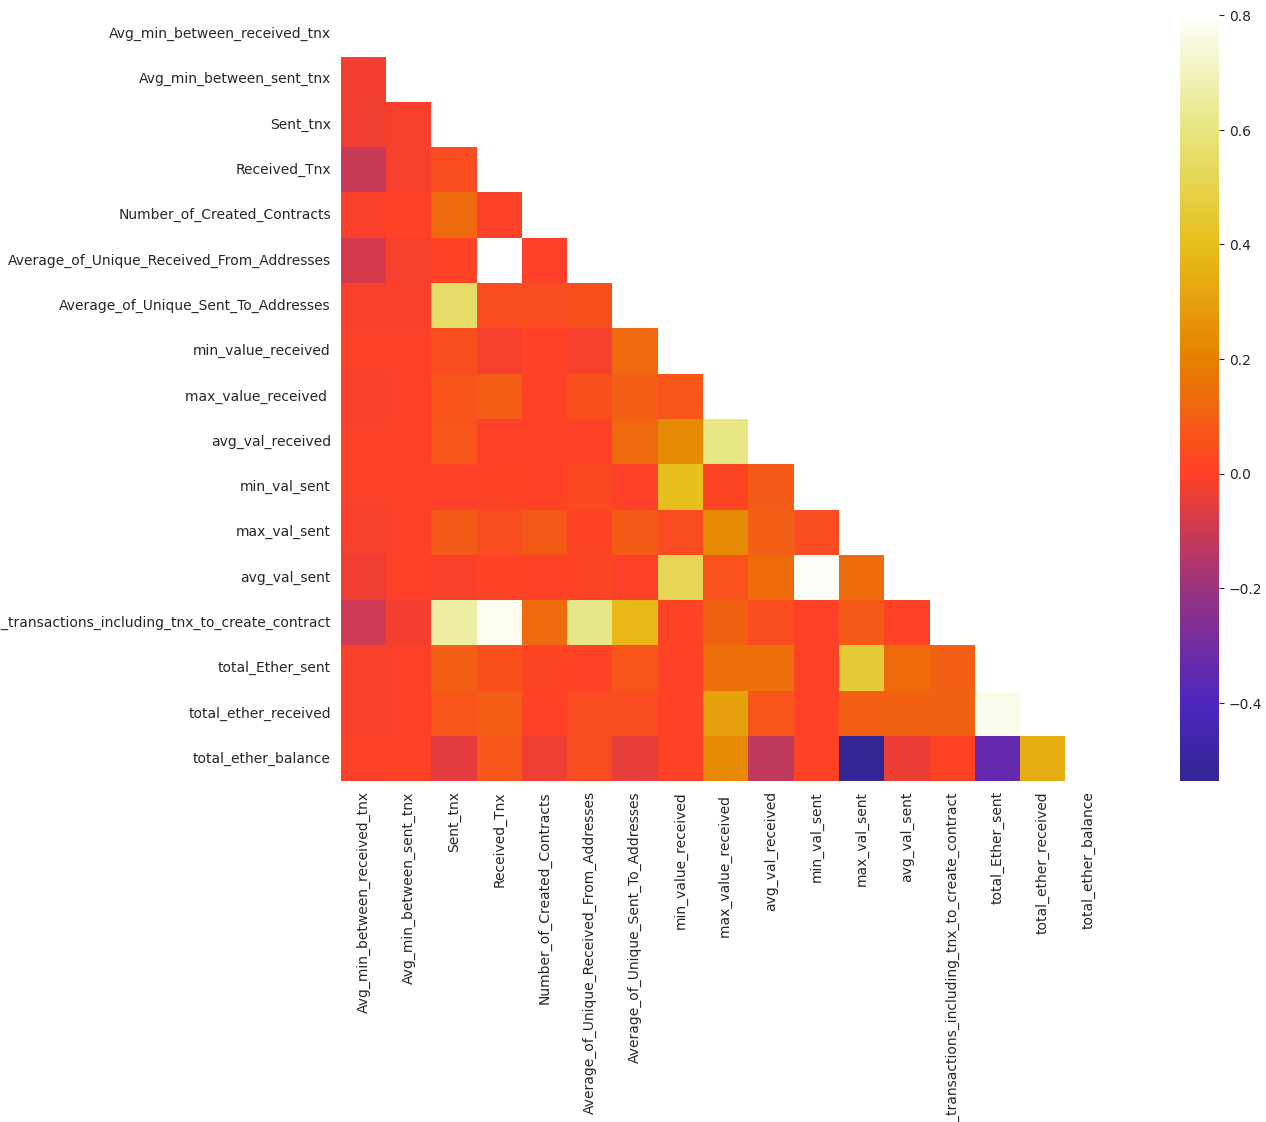

In [10]:
# Correlation analysis

corr = df.iloc[:,2:].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

In [11]:
# Sampling due to imbalanced dataset

positive_sample = df[df["Flag"] == 1]
negative_sample = df[df["Flag"] == 0].sample(len(positive_sample), random_state = RANDOM_STATE)
data = pd.concat([negative_sample, positive_sample], axis = 0)
y = data["Flag"]
X = data.iloc[:,2:]

In [12]:
# Data cleaning

for col in X.columns:
    X[col] = X[col].fillna(X[col].mean())

In [13]:
# Model Training for KNN

knn_params = {"n_neighbors": 15}

knn_model = KNeighborsClassifier(**knn_params)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
knn_cm_worst = None
knn_cm_best = None
knn_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    knn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = knn_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    knn_cm_list.append(cm)
    if knn_cm_worst is None:
        knn_cm_worst = cm
    else:
        if cm.Overall_ACC < knn_cm_worst.Overall_ACC:
            knn_cm_worst = cm

    if knn_cm_best is None:
        knn_cm_best = cm
    else:
        if cm.Overall_ACC > knn_cm_best.Overall_ACC:
            knn_cm_best = cm


Model Name: KNN Classifier

10-Fold Metrics: 

Accuracy : 0.86

F1 : 0.86

Kappa : 0.71

Precision : 0.86

Recall : 0.85



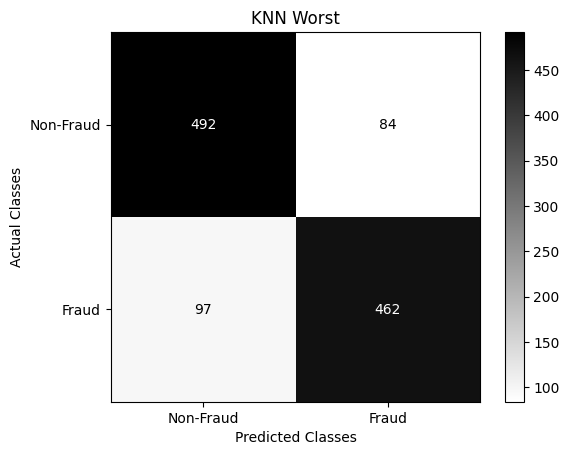

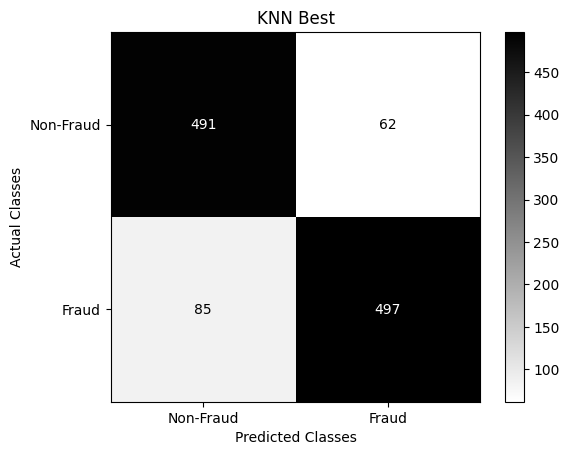

In [14]:
# Model Evaluation for KNN

print("Model Name: KNN Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
knn_cm_worst.plot(title="KNN Worst", number_label=True)
knn_cm_best.plot(title="KNN Best", number_label=True)
plt.show()

In [15]:
# Model Training for RF

rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X, y)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
rf_cm_worst = None
rf_cm_best = None
rf_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    rf_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = rf_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    rf_cm_list.append(cm)
    if rf_cm_worst is None:
        rf_cm_worst = cm
    else:
        if cm.Overall_ACC < rf_cm_worst.Overall_ACC:
            rf_cm_worst = cm

    if rf_cm_best is None:
        rf_cm_best = cm
    else:
        if cm.Overall_ACC > rf_cm_best.Overall_ACC:
            rf_cm_best = cm

Model Name: Random Forest Classifier

10-Fold Metrics: 

Accuracy : 0.89

F1 : 0.89

Kappa : 0.78

Precision : 0.89

Recall : 0.89



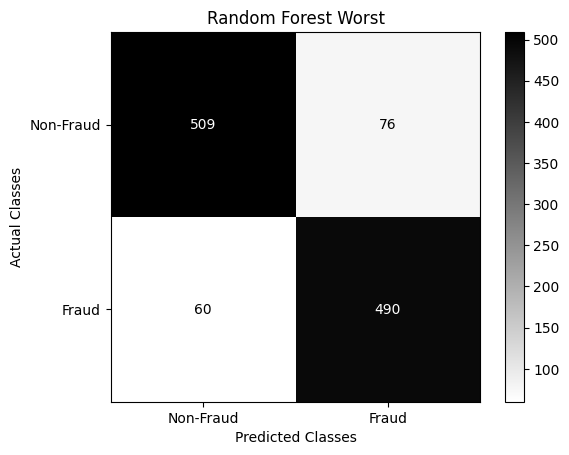

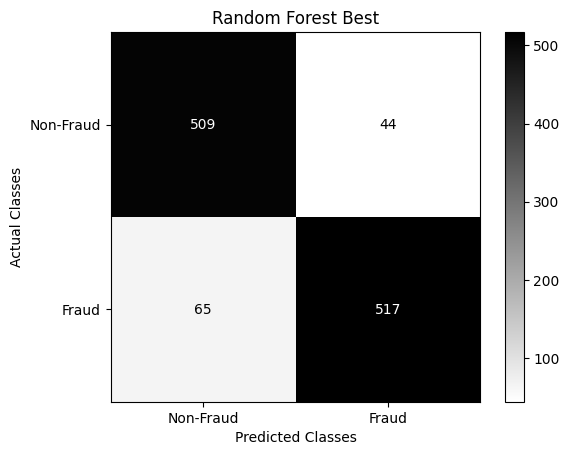

In [16]:
# Model Evaluation for RF

print("Model Name: Random Forest Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
rf_cm_worst.plot(title="Random Forest Worst", number_label=True)
rf_cm_best.plot(title="Random Forest Best", number_label=True)
plt.show()

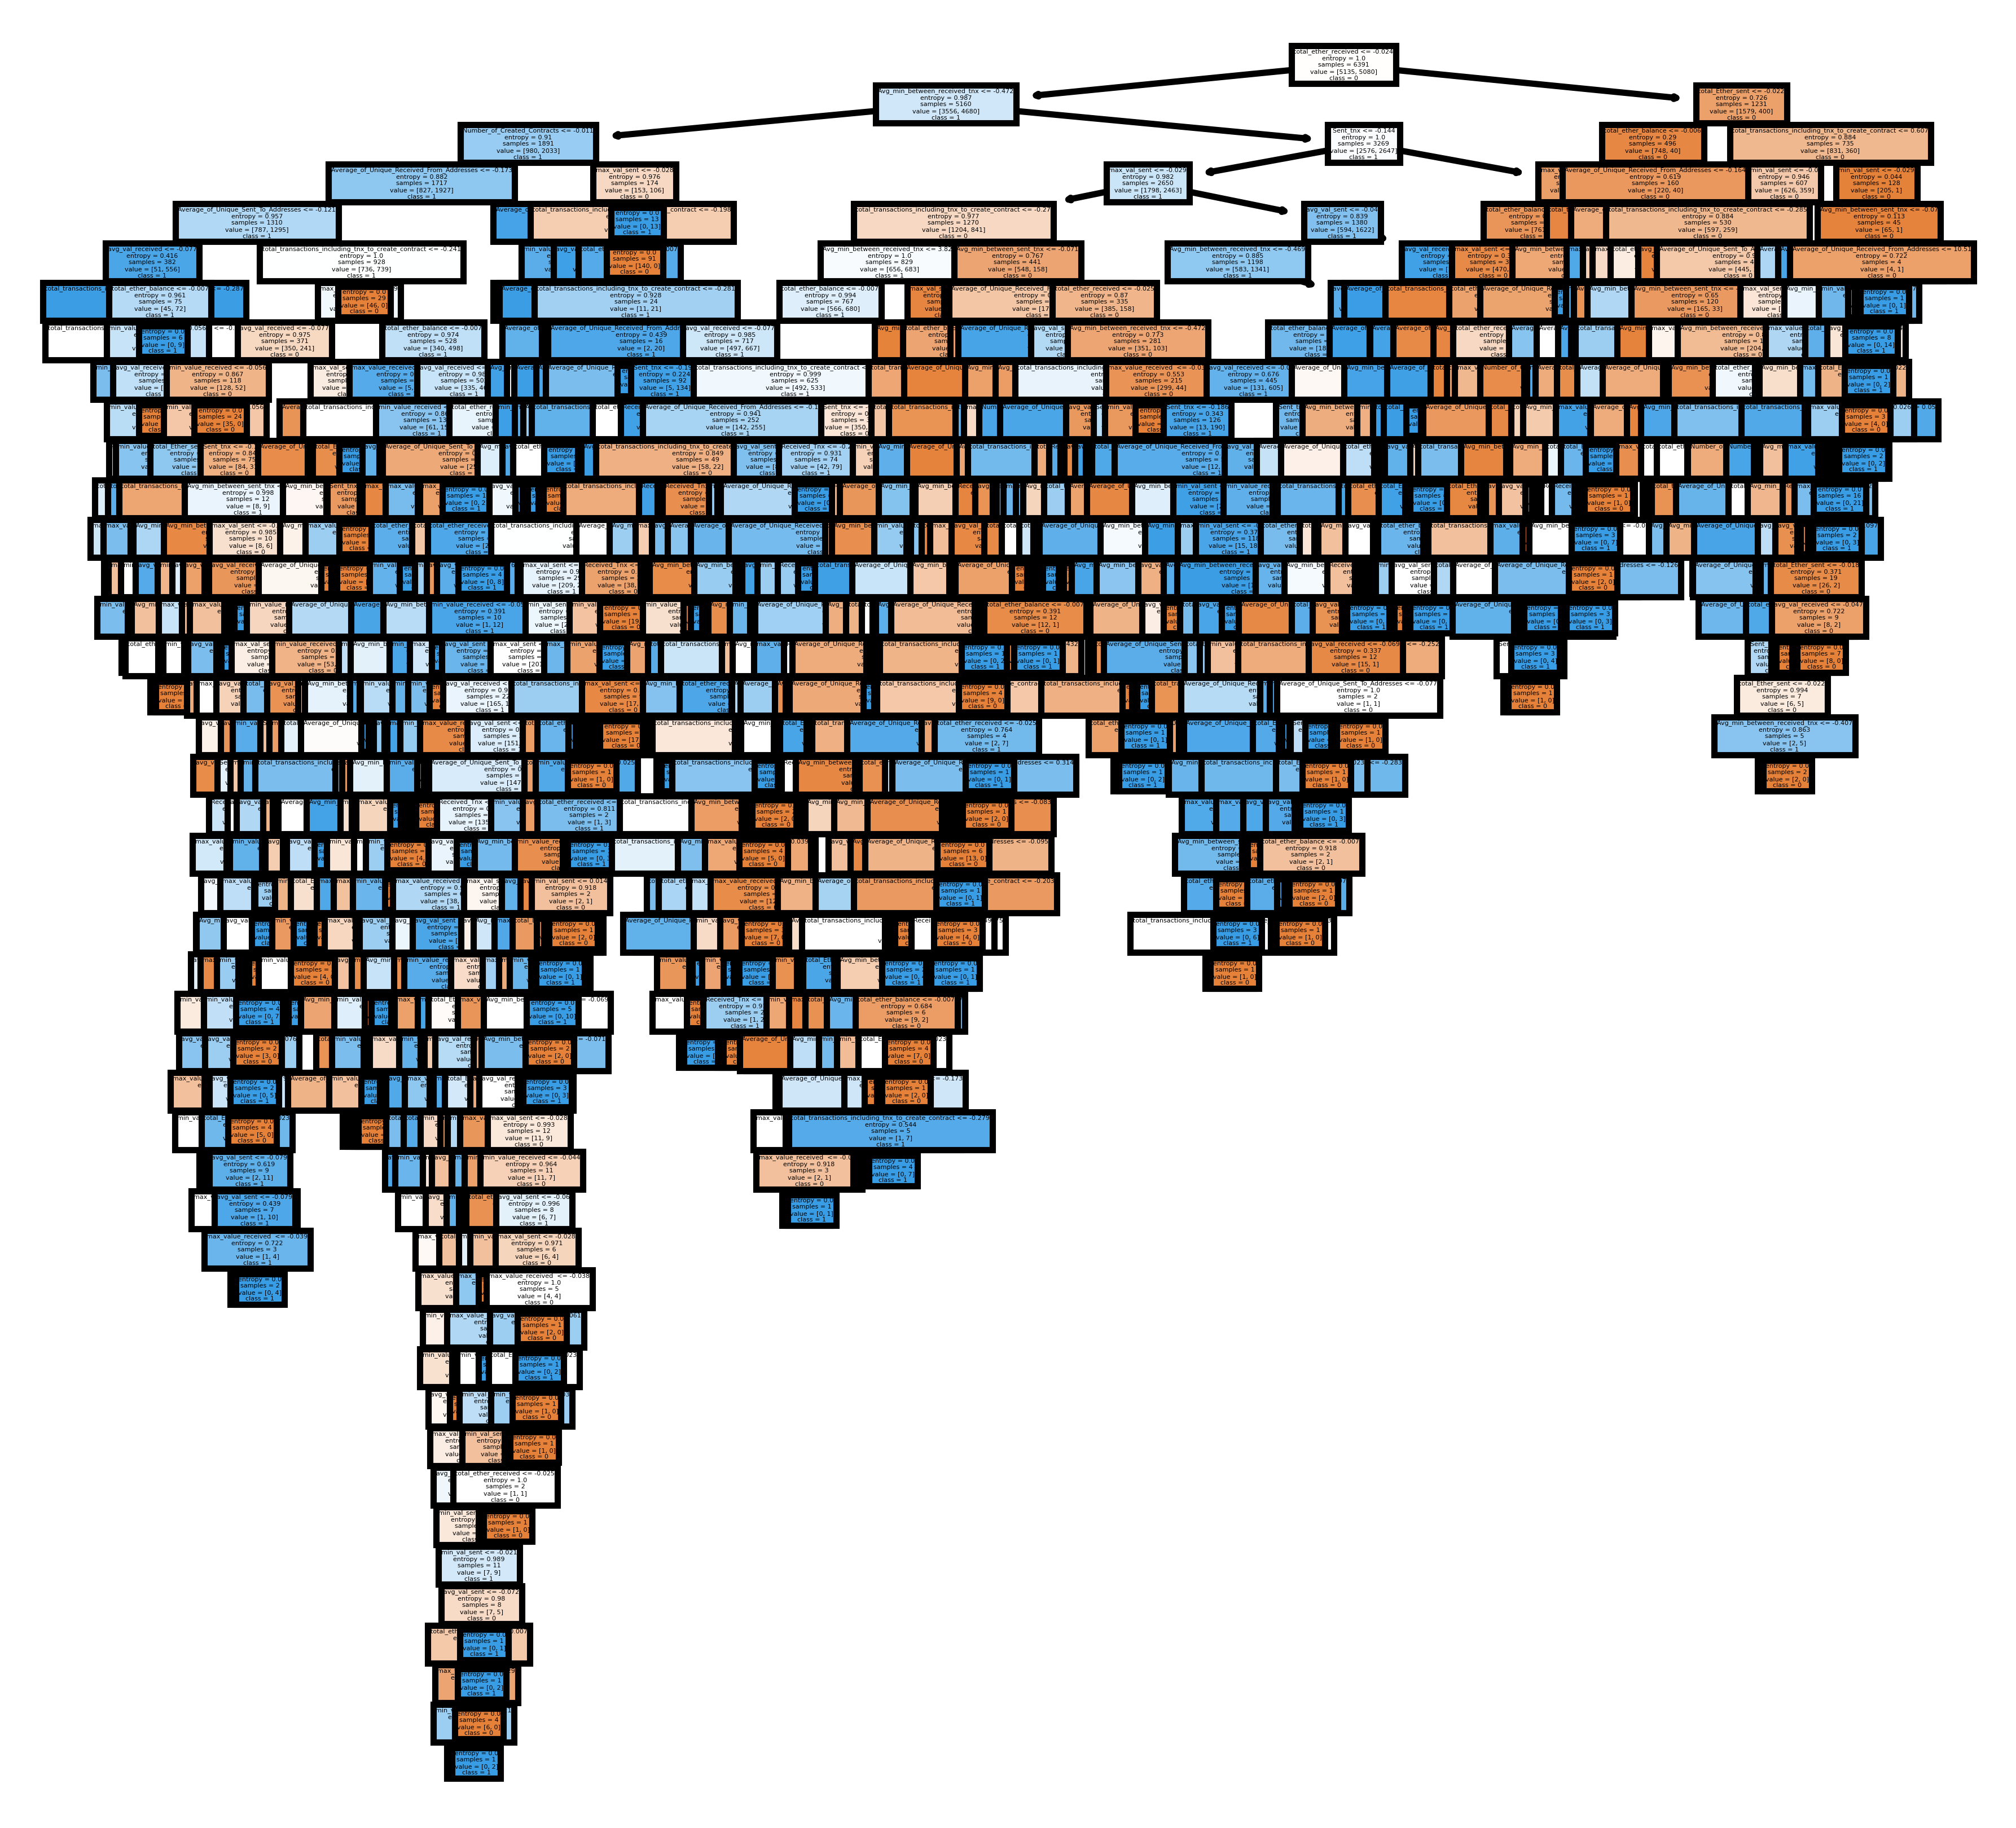

In [23]:
# Model Interpretation
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=800)
plot_tree(rf_model.estimators_[0],
          feature_names= X.columns.tolist(),
            #    feature_names = X.columns, 
            class_names=["0","1"],
            filled = True)
plt.show()


In [24]:
# Feature Importance

pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

Average_of_Unique_Received_From_Addresses              0.119977
Avg_min_between_received_tnx                           0.108819
total_transactions_including_tnx_to_create_contract    0.105907
Sent_tnx                                               0.067966
avg_val_received                                       0.066578
avg_val_sent                                           0.061314
Received_Tnx                                           0.060125
total_ether_received                                   0.057663
min_value_received                                     0.055276
min_val_sent                                           0.050300
max_value_received                                     0.047772
Avg_min_between_sent_tnx                               0.047416
max_val_sent                                           0.047001
total_Ether_sent                                       0.036882
total_ether_balance                                    0.031885
Average_of_Unique_Sent_To_Addresses     

In [25]:
# Model Training for NN

nn_params = {"hidden_layer_sizes": (100, 100), "solver": "adam"}

nn_model = MLPClassifier(**nn_params)
nn_model.fit(X, y)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
nn_cm_worst = None
nn_cm_best = None
nn_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    nn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = nn_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    nn_cm_list.append(cm)
    if nn_cm_worst is None:
        nn_cm_worst = cm
    else:
        if cm.Overall_ACC < nn_cm_worst.Overall_ACC:
            nn_cm_worst = cm

    if nn_cm_best is None:
        nn_cm_best = cm
    else:
        if cm.Overall_ACC > nn_cm_best.Overall_ACC:
            nn_cm_best = cm

/Users/chowshengyang/anaconda3/envs/sy/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/chowshengyang/anaconda3/envs/sy/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Name: Neural Network Classifier
10-Fold Metrics: 

Accuracy : 0.83

F1 : 0.84

Kappa : 0.67

Precision : 0.83

Recall : 0.85



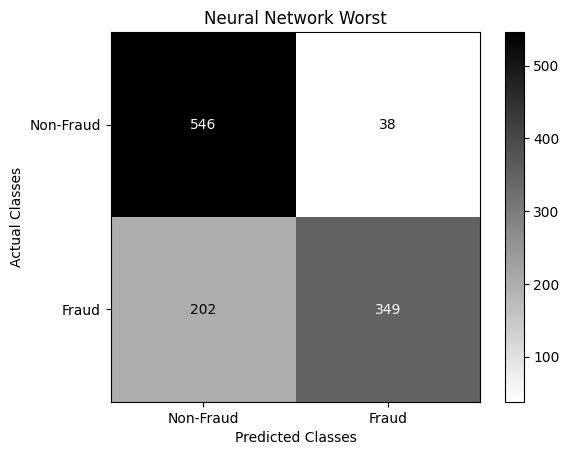

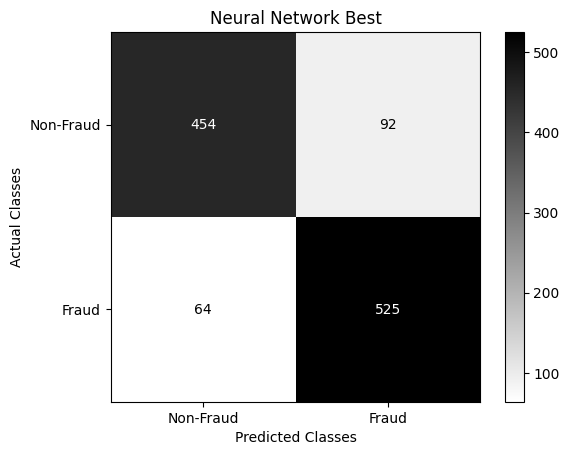

In [26]:
# Model Evaluation for NN

print("Model Name: Neural Network Classifier")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
nn_cm_worst.plot(title="Neural Network Worst", number_label=True)
nn_cm_best.plot(title="Neural Network Best", number_label=True)
plt.show()

In [27]:
# Comparison of Models

rf_combined_cm = None
nn_combined_cm = None
knn_combined_cm = None
for index, cm in enumerate(rf_cm_list):
    if rf_combined_cm is None:
        rf_combined_cm = cm
    else:
        rf_combined_cm = rf_combined_cm.combine(cm)
    
    if nn_combined_cm is None:
        nn_combined_cm = nn_cm_list[index]
    else:
        nn_combined_cm = nn_combined_cm.combine(nn_cm_list[index])
    
    if knn_combined_cm is None:
        knn_combined_cm = knn_cm_list[index]
    else:
        knn_combined_cm = knn_combined_cm.combine(knn_cm_list[index])

In [28]:
# Results of Comparison

cp = Compare({"Random Forest":rf_combined_cm, "Neural Network":nn_combined_cm, "KNN":knn_combined_cm})
print(cp)

Best : Random Forest

Rank   Name              Class-Score       Overall-Score
1      Random Forest     0.76667           0.78095
2      KNN               0.725             0.78095
3      Neural Network    0.65              0.75238

